In [1]:
%matplotlib inline

import json
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

In [2]:
train_dir = '/Users/davidcrompton/Documents/projects/ice_bergs/data/processed/train.json'
test_dir = '/Users/davidcrompton/Documents/projects/ice_bergs/test/processed/test.json'

# Load data and calculate batch sizes
with open(train_dir) as data_file:    
    train_json = json.load(data_file) 
        
with open(test_dir) as data_file:    
    test_json = json.load(data_file)

In [3]:
angle_avg = 40.02188346578265

# Extract samples
def sample_extractor(data_json):
    
    samples = np.zeros((len(data_json), 75, 75, 2))
    angles = np.zeros(len(data_json))

    for index, sample in enumerate(data_json):
        band_1 = np.asarray(sample['band_1']).reshape(75,75)
        band_2 = np.asarray(sample['band_2']).reshape(75,75)
        samples[index][:,:,0] = band_1
        samples[index][:,:,1] = band_2
        inc_angle = sample['inc_angle']
        if isinstance(sample['inc_angle'], str):
            angles[index] = angle_avg
        else: 
            angles[index] = sample['inc_angle']
            
    return samples, angles
    
train_samples, train_angles = sample_extractor(train_json)
test_samples, test_angles = sample_extractor(test_json)

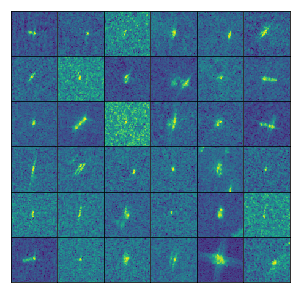

In [4]:
idx = np.random.randint(0, train_samples.shape[0], size=36)
fig, axes = plt.subplots(6, 6, sharex=True, sharey=True, figsize=(5,5),)
for ii, ax in zip(idx, axes.flatten()):
    ax.imshow(train_samples[ii,:,:,0], aspect='equal')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.subplots_adjust(wspace=0, hspace=0)

In [5]:
def scale(x, feature_range=(-1, 1)):
    # scale to (0, 1)
    OldRange = (37.090523 - -49.0835)  # 37.090523 is the max pixel value, -49.0835 is the minimum
    NewRange = (1 - 0)  
    x = (((x - -49.0835) * NewRange) / OldRange) + 0
    
    # scale to feature_range
    min, max = feature_range
    x = x * (max - min) + min
    return x

In [15]:
class Dataset:
    def __init__(self, train, test, val_frac=0.5, shuffle=False, scale_func=None):
        split_idx = int(len(train_samples)*(1 - val_frac))
        self.test_x, self.valid_x = test_samples[:split_idx,:,:,:], test_samples[split_idx:,:,:,:]
        self.train_x = test_samples[0:100] #Remove for full training

        
        if scale_func is None:
            self.scaler = scale
        else:
            self.scaler = scale_func
        self.shuffle = shuffle
        
    def batches(self, batch_size):
        if self.shuffle:
            idx = np.arange(len(dataset.train_x))
            np.random.shuffle(idx)
            self.train_x = self.train_x[idx]
        
        n_batches = len(self.train_x)//batch_size
        for ii in range(0, len(self.train_x), batch_size):
            x = self.train_x[ii:ii+batch_size]
            yield self.scaler(x)

In [7]:
def model_inputs(real_dim, z_dim):
    inputs_real = tf.placeholder(tf.float32, (None, *real_dim), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    
    return inputs_real, inputs_z

In [8]:
def generator(z, output_dim, reuse=False, alpha=0.2, training=True):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, 4*4*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=training)
        x1 = tf.maximum(alpha * x1, x1)
        # 4x4x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=training)
        x2 = tf.maximum(alpha * x2, x2)
        # 8x8x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=training)
        x3 = tf.maximum(alpha * x3, x3)
        # 16x16x128 now
        
        x4 = tf.layers.conv2d_transpose(x3, 64, 5, strides=2, padding='same')
        x4 = tf.layers.batch_normalization(x4, training=training)
        x4 = tf.maximum(alpha * x4, x4)
        # 32x32x64 now
        
        x5 = tf.layers.conv2d_transpose(x4, 128, 5, strides=2, padding='same')
        x5 = tf.layers.batch_normalization(x5, training=training)
        x5 = tf.maximum(alpha * x5, x5)
        # 64x64x32 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x5, 2, 5, strides=2, padding='same')
        
        
        logits = tf.image.resize_image_with_crop_or_pad(
            logits,
            75,
            75
        )
        # 75x75x2 now
        
        out = tf.tanh(logits)
        
        return out

In [9]:
def discriminator(x, reuse=False, alpha=0.2):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 75x75x2
        x0 = tf.layers.conv2d(x, 32, (64,64), strides=2, padding='same')
        relu0 = tf.maximum(alpha * x0, x0)
        
        x1 = tf.layers.conv2d(relu0, 64, (32,32), strides=2, padding='same')
        bn1 = tf.layers.batch_normalization(x1, training=True)
        relu1 = tf.maximum(alpha * bn1, bn1)
        # 32x32x64
        
        x2 = tf.layers.conv2d(relu1, 128, (16,16), strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 16x16x128
        
        x3 = tf.layers.conv2d(relu2, 256, (8,8), strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 8x8x256
        
        x4 = tf.layers.conv2d(relu3, 512, (4,4), strides=2, padding='same')
        bn4 = tf.layers.batch_normalization(x4, training=True)
        relu4 = tf.maximum(alpha * bn4, bn4)

        # Flatten it
        flat = tf.reshape(relu4, (-1, 4*4*512))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits

In [10]:
def model_loss(input_real, input_z, output_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, output_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

In [11]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

In [12]:
class GAN:
    def __init__(self, real_size, z_size, learning_rate, alpha=0.2, beta1=0.5):
        tf.reset_default_graph()
        
        self.input_real, self.input_z = model_inputs(real_size, z_size)
        
        self.d_loss, self.g_loss = model_loss(self.input_real, self.input_z,
                                              real_size[2], alpha=alpha)
        
        self.d_opt, self.g_opt = model_opt(self.d_loss, self.g_loss, learning_rate, beta1)

In [13]:
def view_samples(epoch, samples, nrows, ncols, figsize=(5,5)):
    fig, axes = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols, 
                             sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.axis('off')
        NewRange = (37.090523 - -49.0835)  # 37.090523 is the max pixel value, -49.0835 is the minimum
        OldRange = (1 - 0)  
        img = (((img - 0) * NewRange) / OldRange) + -49.0835
        ax.set_adjustable('box-forced')
        im = ax.imshow(img[:,:,0], aspect='equal')
   
    plt.subplots_adjust(wspace=0, hspace=0)
    return fig, axes

In [25]:
def train(net, dataset, epochs, batch_size, print_every=1, show_every=1, figsize=(5,5)):
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(72, z_size))

    samples, losses = [], []
    steps = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epochs):
            for x in dataset.batches(batch_size):
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))

                # Run optimizers
                try:
                    _ = sess.run(net.d_opt, feed_dict={net.input_real: x, net.input_z: batch_z})
                    _ = sess.run(net.g_opt, feed_dict={net.input_z: batch_z, net.input_real: x})
                except Exception:
                    pass

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    try:
                        train_loss_d = net.d_loss.eval({net.input_z: batch_z, net.input_real: x})
                        train_loss_g = net.g_loss.eval({net.input_z: batch_z})
                    except Exception:
                        pass

                    print("Epoch {}/{}...".format(e+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    gen_samples = sess.run(
                                   generator(net.input_z, 2, reuse=True, training=False),
                                   feed_dict={net.input_z: sample_z})
                    samples.append(gen_samples)
                    _ = view_samples(-1, samples, 6, 12, figsize=figsize)
                    plt.show()

        #saver.save(sess, './checkpoints/generator.ckpt')

    #with open('samples.pkl', 'wb') as f:
        #pkl.dump(samples, f)
    
    return losses, samples

In [26]:
real_size = (75,75,2)
z_size = 100
learning_rate = 0.0002
batch_size = 32
epochs = 1
alpha = 0.2
beta1 = 0.5

# Create the network
net = GAN(real_size, z_size, learning_rate, alpha=alpha, beta1=beta1)

Epoch 1/1... Discriminator Loss: 1.2795... Generator Loss: 4.2438


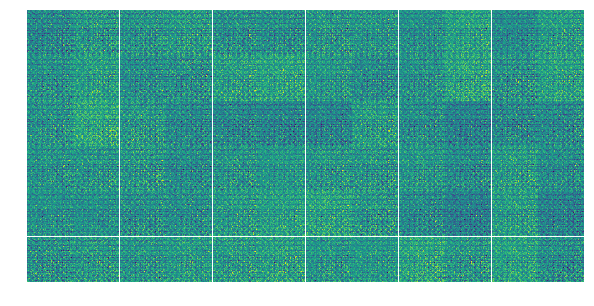

Epoch 1/1... Discriminator Loss: 2.6989... Generator Loss: 1.7460


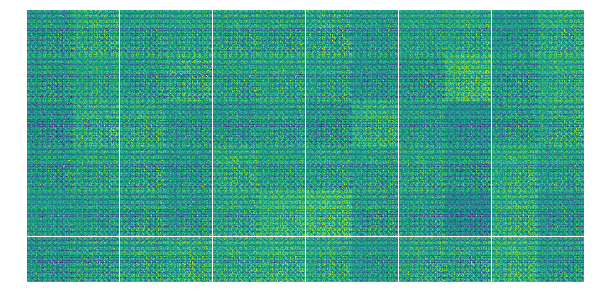

Epoch 1/1... Discriminator Loss: 2.5405... Generator Loss: 1.3573


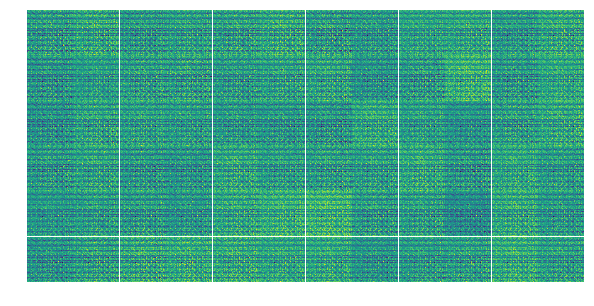

Epoch 1/1... Discriminator Loss: 2.5405... Generator Loss: 1.3573


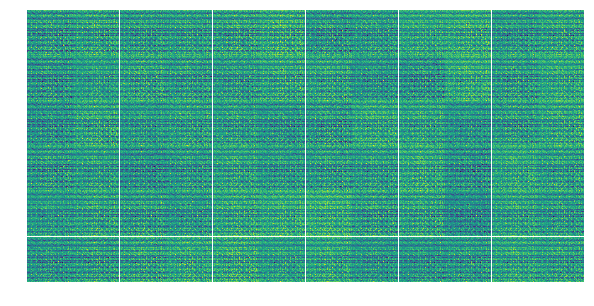

In [27]:
dataset = Dataset(train_samples, test_samples)

losses, samples = train(net, dataset, epochs, batch_size, figsize=(10,5))